# Assignment

## Instructions

In this assignment, you will apply time series forecasting techniques to analyze and predict future values. You will work with the "Global Temperature Time Series" dataset, which contains monthly temperature anomalies from 1880 to present day.

### Task: Global Temperature Forecasting

Your task is to analyze the global temperature time series and build forecasting models to predict future temperature trends. Follow these steps:

1. **Data Exploration**

   - Load and prepare the dataset
   - Visualize the time series data
   - Check for trends, seasonality, and cycles
   - Create seasonal plots and subseries plots
   - Analyze autocorrelation using ACF plots

2. **Time Series Decomposition**

   - Decompose the time series into trend, seasonal, and residual components
   - Compare additive and multiplicative decomposition methods
   - Interpret your findings

3. **Forecasting**

   - Split the data into training and testing sets using a temporal split
   - Implement and evaluate the following forecasting methods:
     - Naive forecasting (last value and seasonal naive)
     - ARIMA/SARIMA models
     - Exponential smoothing models
   - Use appropriate evaluation metrics (MAE, MAPE, sMAPE) to compare model performance

4. **Model Selection and Interpretation**
   - Determine which model performs best for this dataset
   - Interpret the results and explain why certain models might work better than others
   - Generate forecasts for future periods

### Starter Code

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset (NASA GISTEMP Global Temperature Anomaly)
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"

# Data preparation
def prepare_nasa_data(url):
    # Read the data, skipping the header explanation
    df = pd.read_csv(url, skiprows=1)

    # Remove the unnecessary columns
    df = df.iloc[:, :13]

    # Rename columns
    df.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Convert from wide to long format
    df_long = df.melt(id_vars=['Year'],
                       var_name='Month',
                       value_name='Temperature_Anomaly')

    # Filter out missing or invalid data
    df_long = df_long[df_long['Temperature_Anomaly'] != '***']
    df_long['Temperature_Anomaly'] = df_long['Temperature_Anomaly'].astype(float)

    # Create a proper date index
    df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'], format='%Y-%b')

    # Sort by date
    df_long = df_long.sort_values('Date')

    # Create a time series
    ts_data = df_long.set_index('Date')['Temperature_Anomaly']

    return ts_data

# Prepare the time series data
ts_data = prepare_nasa_data(url)
ts_data

Date
1880-01-01   -0.19
1880-02-01   -0.25
1880-03-01   -0.10
1880-04-01   -0.17
1880-05-01   -0.11
              ... 
2025-08-01    1.16
2025-09-01    1.25
2025-10-01    1.19
2025-11-01    1.21
2025-12-01    1.05
Name: Temperature_Anomaly, Length: 1752, dtype: float64

In [3]:
# Now you have a time series object 'ts_data' to work with
print(f"Time series data from {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Total number of observations: {len(ts_data)}")

Time series data from 1880-01-01 00:00:00 to 2025-12-01 00:00:00
Total number of observations: 1752


#### Time Series Plot

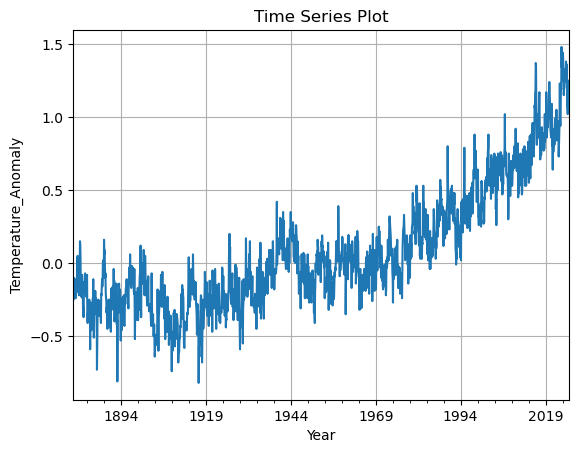

In [4]:
# TODO: Explore and visualize the time series data
# HINT: Use time series plots, seasonal plots, and autocorrelation plots

# Time Series Plot
ts_data.plot()
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel(ts_data.name)
plt.grid(True)
plt.show()

#### Seasonal Plot

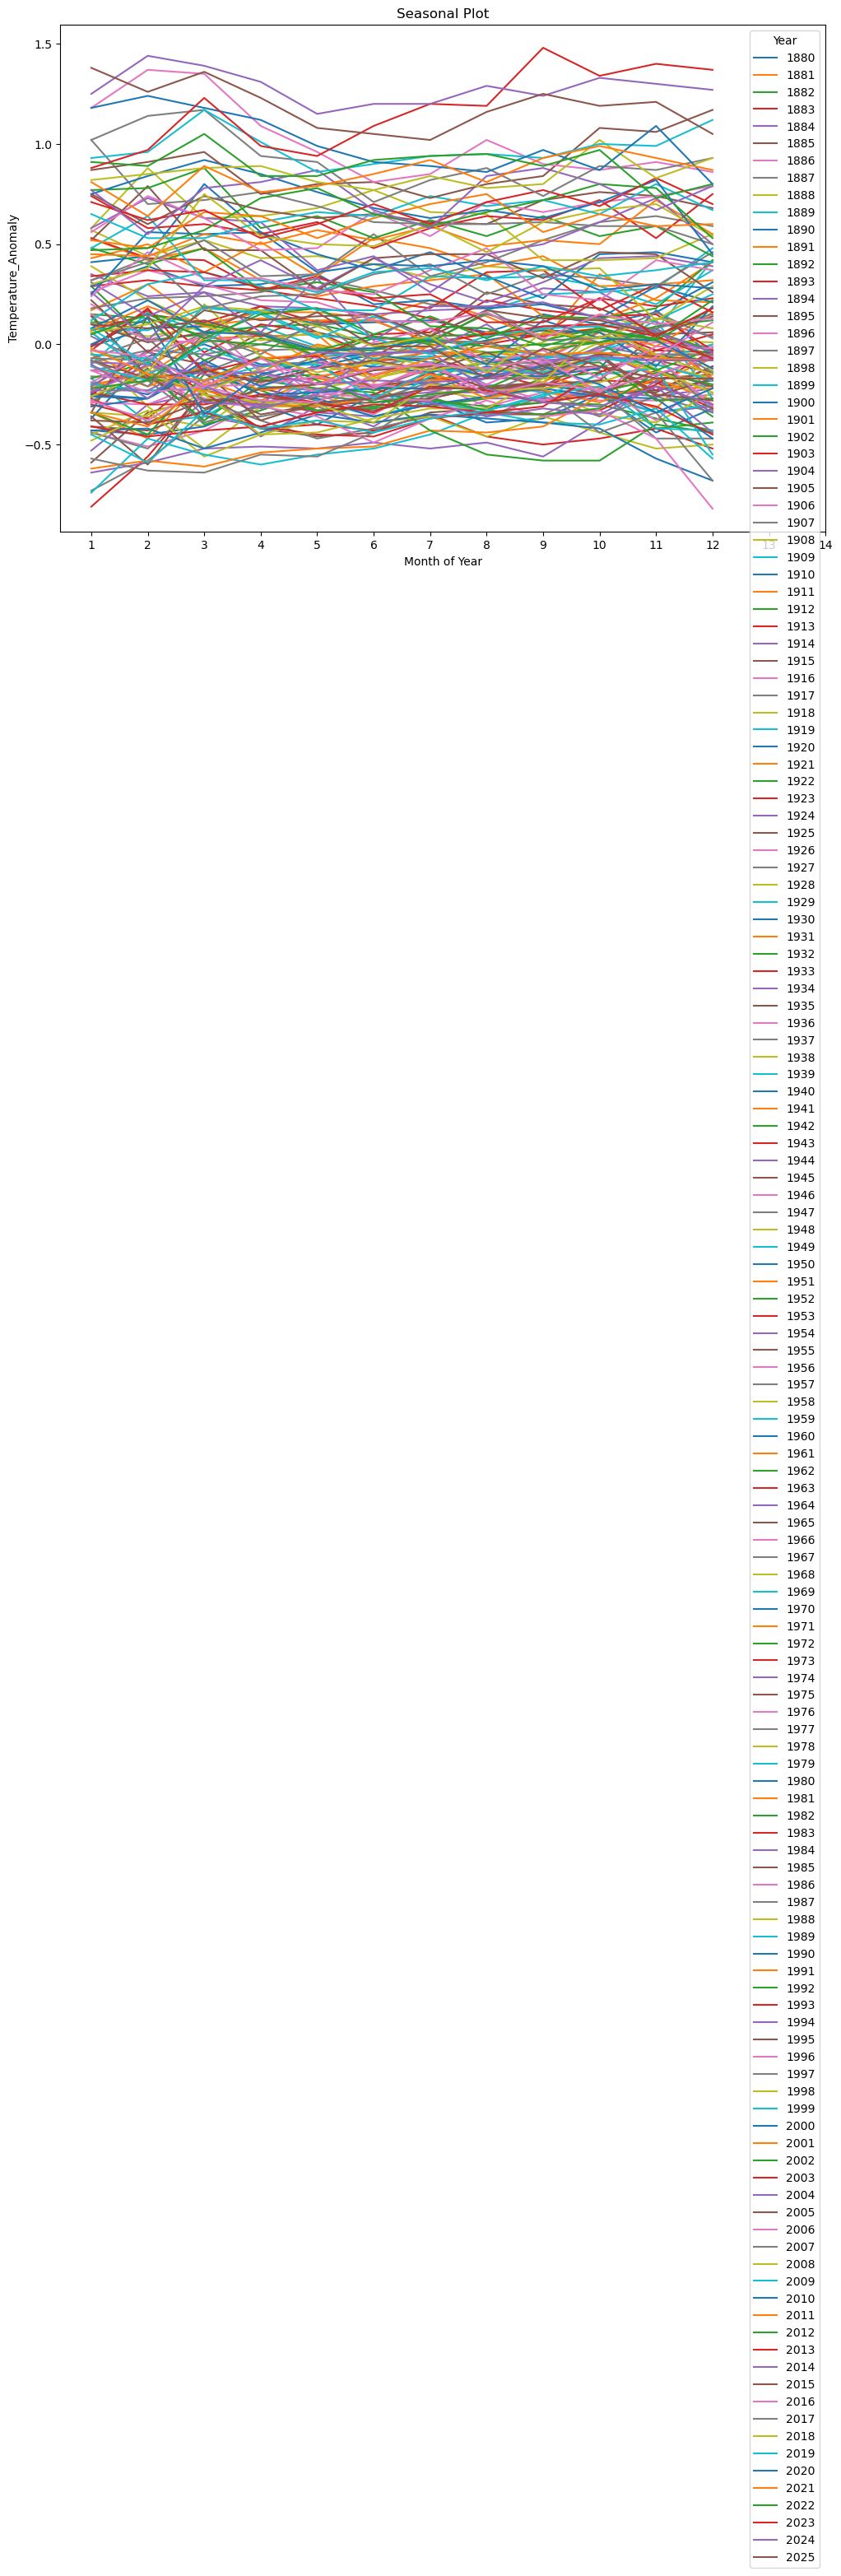

In [5]:
# Seasonal Plot
years = ts_data.index.year.unique()
plt.figure(figsize=(12, 8))
for year in years:
    plt.plot(ts_data[ts_data.index.year == year].index.month, ts_data[ts_data.index.year == year], label=year)

plt.title('Seasonal Plot')
plt.xlabel('Month of Year')
plt.xticks(range(1, 15))
plt.ylabel(ts_data.name)
plt.legend(title='Year')
plt.show()

#### Subseries Plot

In [6]:
# Subseries Plot
dates = ts_data.index.astype('datetime64[ns]')
ts_data_df = ts_data.reset_index(name='value')
ts_data_df['month'] = dates.strftime('%b')
ts_data_df['year'] = dates.year.astype(int)
ts_data_df

,Date,value,month,year
0,1880-01-01,-0.19,Jan,1880
1,1880-02-01,-0.25,Feb,1880
2,1880-03-01,-0.10,Mar,1880
3,1880-04-01,-0.17,Apr,1880
4,1880-05-01,-0.11,May,1880
...,...,...,...,...
1747,2025-08-01,1.16,Aug,2025
1748,2025-09-01,1.25,Sep,2025
1749,2025-10-01,1.19,Oct,2025
1750,2025-11-01,1.21,Nov,2025


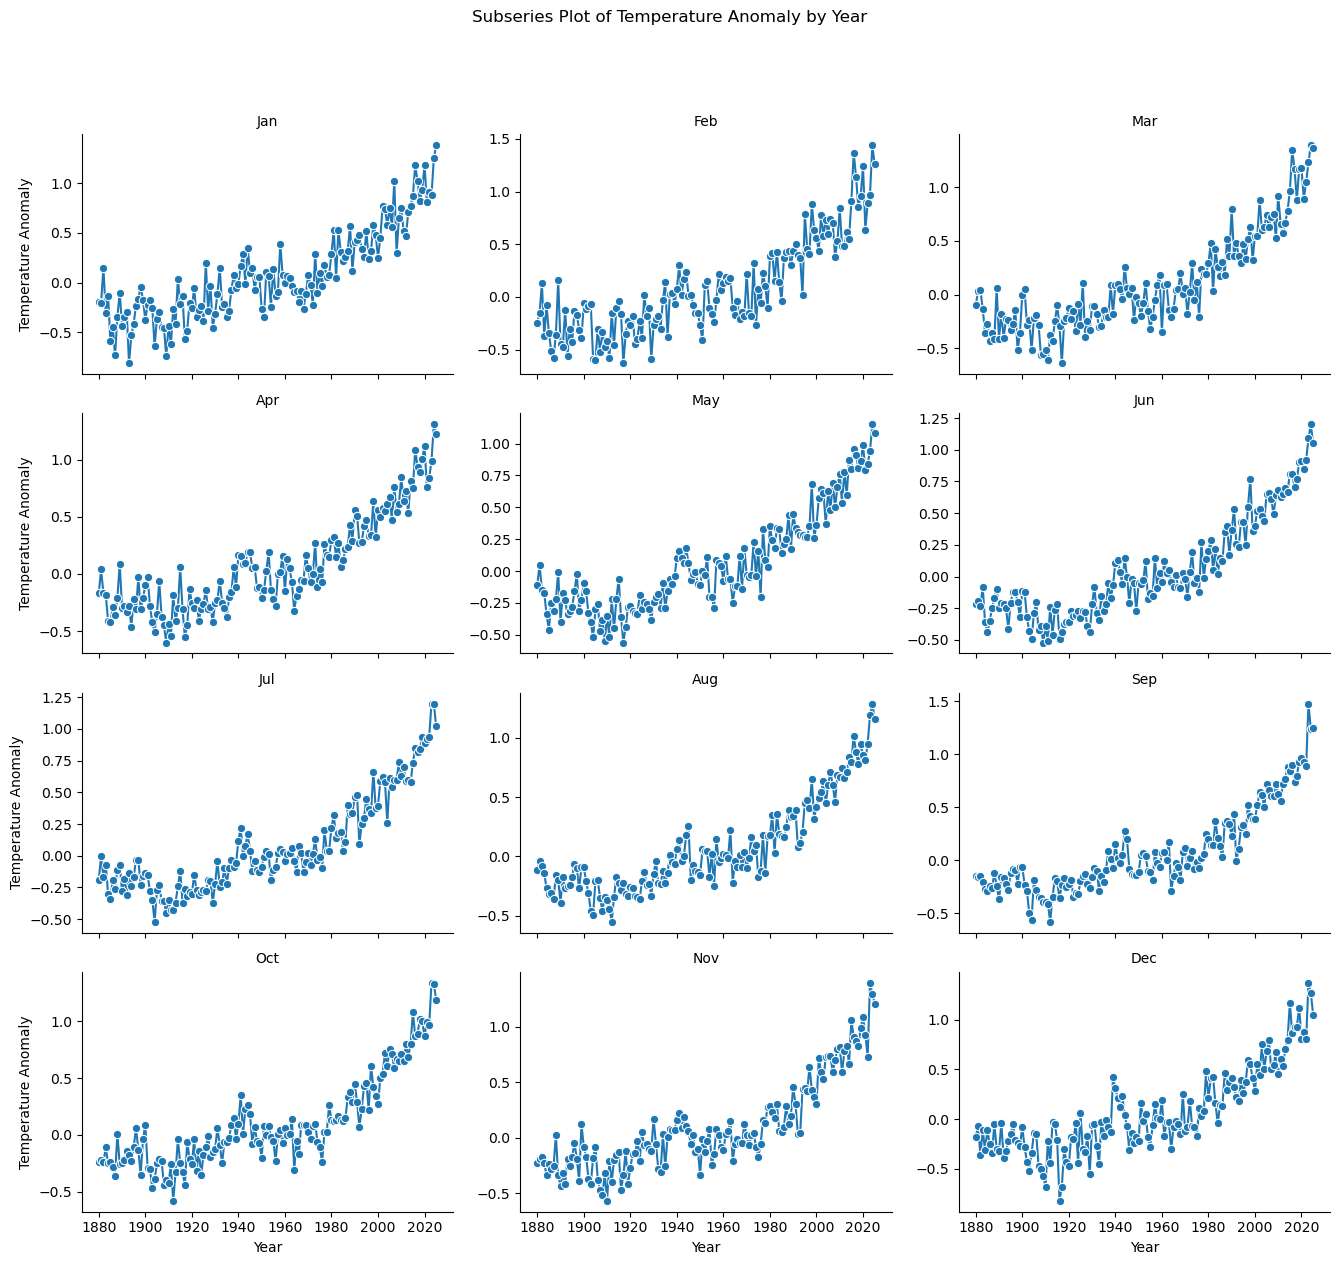

In [7]:
g = sns.FacetGrid(ts_data_df, col="month", col_wrap=3, height=3, aspect=1.5, sharey=False)
g.map(sns.lineplot, "year", "value", marker='o')
g.set_axis_labels('Year', 'Temperature Anomaly')
g.set_titles("{col_name}")
g.fig.suptitle('Subseries Plot of Temperature Anomaly by Year', y=1.05)
g.tight_layout()

#### Lag Plot

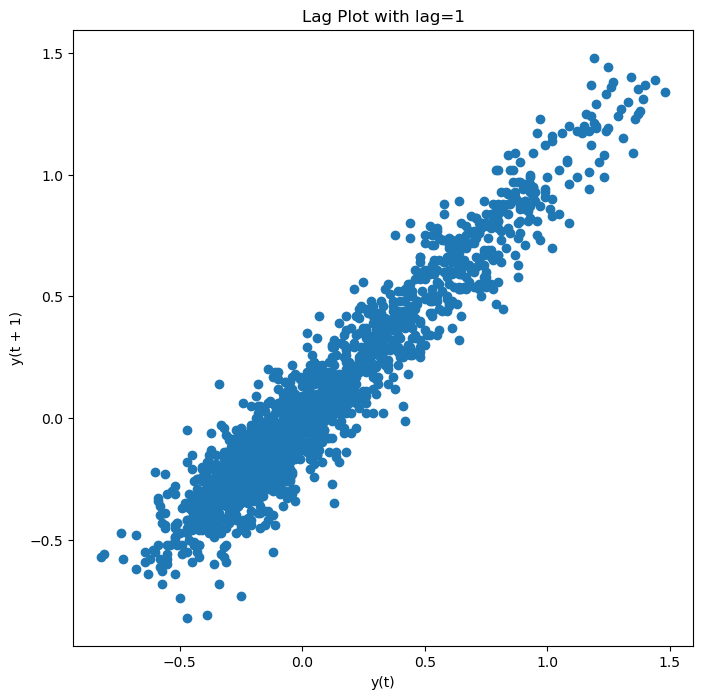

In [8]:
# Lag Plot
plt.figure(figsize=(8, 8))
lag_plot(ts_data, lag=1)
plt.title('Lag Plot with lag=1')
plt.show()

#### Autocorrelation Function (ACF) Plot

In [9]:
# Autocorrelation Function (ACF) Plot
autocorrelations = acf(ts_data, nlags=60)
print(f'Autocorrelations: {autocorrelations}')

Autocorrelations: [1.         0.95602199 0.94117422 0.92704047 0.91926381 0.9101857
 0.90360238 0.89677987 0.89160994 0.88520181 0.87913435 0.87449264
 0.87066947 0.86321767 0.85535688 0.84559796 0.84187651 0.83770325
 0.83409778 0.83198031 0.82899731 0.82849224 0.82626235 0.82430609
 0.82577149 0.81678668 0.81058801 0.804175   0.80012846 0.79616443
 0.79282109 0.79074569 0.79091524 0.79325077 0.7920991  0.7938151
 0.79255457 0.79037319 0.78919305 0.78359061 0.78368196 0.78347058
 0.7820732  0.78123187 0.78119566 0.78052718 0.77691872 0.77586354
 0.77854466 0.77585966 0.77304866 0.76822687 0.76368278 0.76117304
 0.75806623 0.75621464 0.75555856 0.75423595 0.75220229 0.75170382
 0.74824598]


<Figure size 1200x600 with 0 Axes>

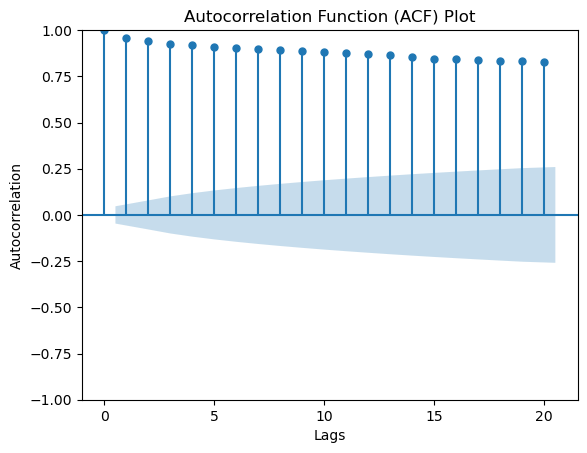

In [10]:
plt.figure(figsize=(12, 6))
plot_acf(ts_data, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [11]:
print(f'Mean: {ts_data.mean()}')
print(f'Variance: {ts_data.var()}')

Mean: 0.08142123287671234
Variance: 0.17243195952606358


In [12]:
from statsmodels.tsa.stattools import q_stat
from scipy.stats import shapiro, levene
import numpy as np

def is_white_noise(series, lags=20, alpha=0.05):
    # 1. Autocorrelation check (Ljung-Box)
    _, pvals = q_stat(acf(series, nlags=lags)[1:], len(series))
    acf_ok = all(p > alpha for p in pvals)
    
    # 2. Constant variance check (Levene's test on halves)
    split = len(series)//2
    _, pval_var = levene(series[:split], series[split:])
    var_ok = pval_var > alpha
    
    # 3. Normality check (Shapiro-Wilk)
    _, pval_norm = shapiro(series)
    norm_ok = pval_norm > alpha
    
    return all([acf_ok, var_ok, norm_ok])

print(f'Is White Noise: {is_white_noise(ts_data)}')

Is White Noise: False


#### Time Series Decomposition: trend, seasonal, and residual components, additive and multiplicative decomposition methods

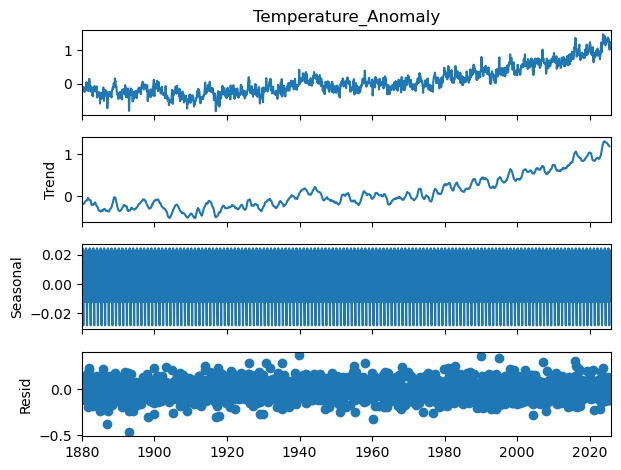

<Figure size 12000x1600 with 0 Axes>

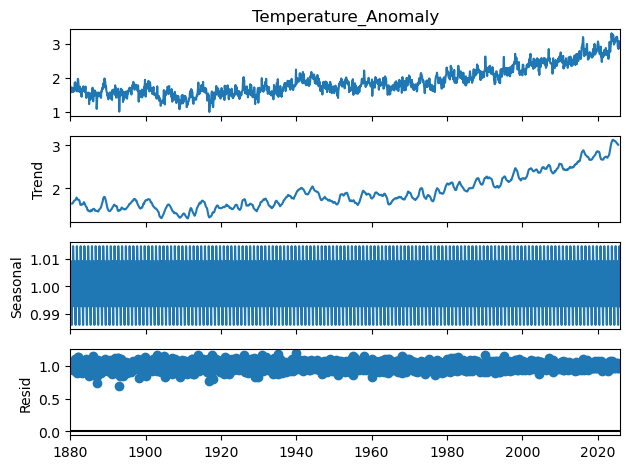

In [13]:
# TODO: Perform time series decomposition
# HINT: Try both additive and multiplicative decomposition

ts_data.index = dates

# Perform additive decomposition
decomposition = seasonal_decompose(ts_data, model='additive')

# Plot the decomposed components
fig = decomposition.plot()
plt.figure(figsize=(120, 16))
plt.show()

# Perform multiplicative decomposition
# make all values positive, as multiplicative cannot take in negative values
shift_value = abs(ts_data.min()) + 1
ts_data_positive = ts_data + shift_value
ts_data_positive

decomposition = seasonal_decompose(ts_data_positive, model='multiplicative')

# Plot the decomposed components
fig = decomposition.plot()
plt.show()


In [14]:
# TODO: Split the data into training and testing sets
# HINT: Use temporal_train_test_split with the last 36 months as test data

y = ts_data
y.sort_index()
y_train, y_test = temporal_train_test_split(y, test_size=36)
y_test

Date
2023-01-01    0.88
2023-02-01    0.97
2023-03-01    1.23
2023-04-01    0.99
2023-05-01    0.94
2023-06-01    1.09
2023-07-01    1.20
2023-08-01    1.19
2023-09-01    1.48
2023-10-01    1.34
2023-11-01    1.40
2023-12-01    1.37
2024-01-01    1.25
2024-02-01    1.44
2024-03-01    1.39
2024-04-01    1.31
2024-05-01    1.15
2024-06-01    1.20
2024-07-01    1.20
2024-08-01    1.29
2024-09-01    1.24
2024-10-01    1.33
2024-11-01    1.30
2024-12-01    1.27
2025-01-01    1.38
2025-02-01    1.26
2025-03-01    1.36
2025-04-01    1.23
2025-05-01    1.08
2025-06-01    1.05
2025-07-01    1.02
2025-08-01    1.16
2025-09-01    1.25
2025-10-01    1.19
2025-11-01    1.21
2025-12-01    1.05
Name: Temperature_Anomaly, dtype: float64

In [15]:
y_train

Date
1880-01-01   -0.19
1880-02-01   -0.25
1880-03-01   -0.10
1880-04-01   -0.17
1880-05-01   -0.11
              ... 
2022-08-01    0.95
2022-09-01    0.89
2022-10-01    0.97
2022-11-01    0.73
2022-12-01    0.80
Name: Temperature_Anomaly, Length: 1716, dtype: float64

#### Naive forecasting

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temperature_Anomaly'>)

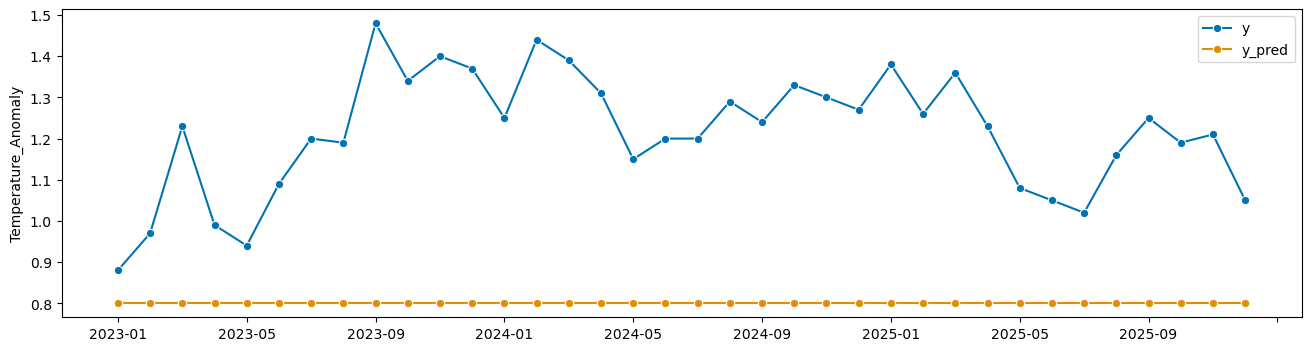

In [16]:
# TODO: Implement and evaluate different forecasting methods
# HINT: Try naive forecasting, ARIMA, and ETS models

# naive forecasting
y_train.index = pd.to_datetime(y_train.index).to_period('M')
y_test.index = pd.to_datetime(y_test.index).to_period('M')

# Initialize the naive forecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# Define the forecasting horizon
fh = np.arange(1, len(y_test) + 1)

y_pred = forecaster.predict(fh=fh)

# plotting predictions and past data
plot_series(y_test, y_pred, labels=["y", "y_pred"])

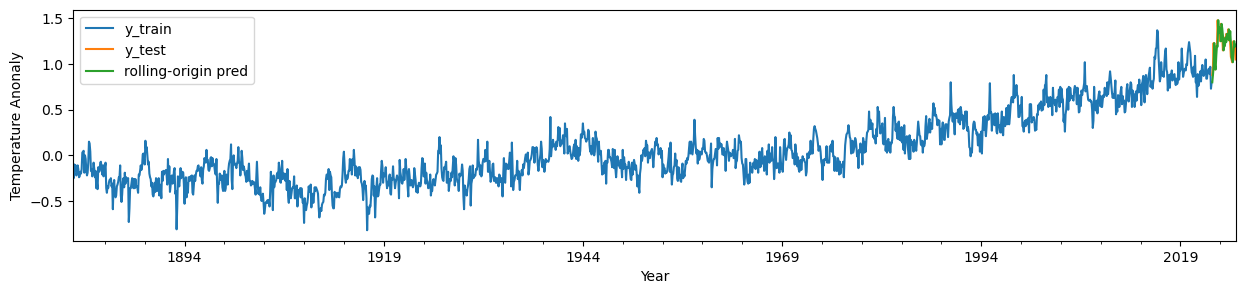

In [17]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

history = y_train.copy()
pred_vals = []

for stamp in y_test.index:
    pred_vals.append(history.iloc[-1])          # forecast using current history
    history.loc[stamp] = y_test.loc[stamp]      # once actual arrives, add it

y_pred = pd.Series(pred_vals, index=y_test.index)

fig, ax = plt.subplots(figsize=(15, 3))
y_train.plot(ax=ax, label="y_train")
y_test.plot(ax=ax, label="y_test")
y_pred.plot(ax=ax, label="rolling-origin pred")
ax.set_ylabel("Temperature Anonaly")
ax.set_xlabel("Year")
ax.legend()
plt.show()

In [18]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=True)

0.08354109456767606

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temperature_Anomaly'>)

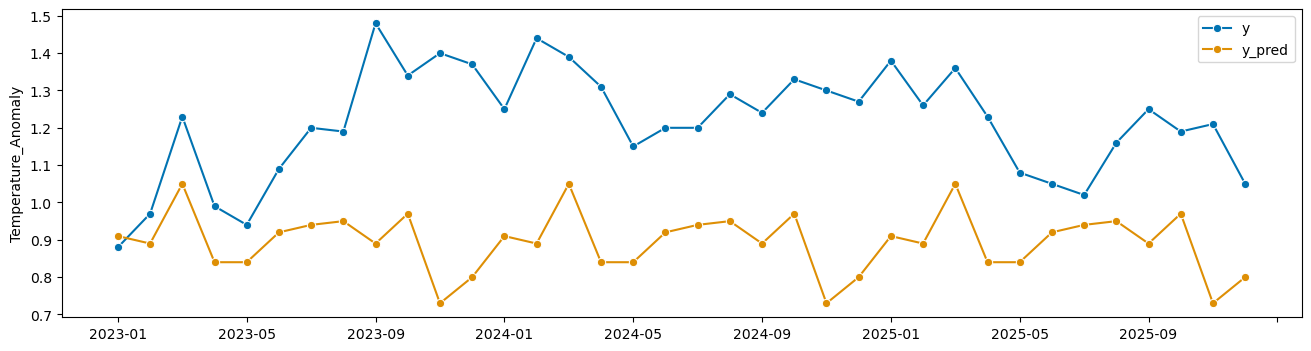

In [19]:
# Initialize the seasonal naive forecaster
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=fh)

# plotting predictions and past data
plot_series(y_test, y_pred, labels=["y", "y_pred"])

In [20]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=True)

0.3000551896252267

#### ARIMA

In [21]:
# Set the ARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12

# Initialize the ARIMA model
arima_model = ARIMA(order=(p, d, q), seasonal_order=(P, D, Q, m), suppress_warnings=True)

# Fit the model
arima_model.fit(y_train)

ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

In [22]:
# Initialize the AutoARIMA model
auto_arima_model = AutoARIMA(sp=12, suppress_warnings=True, stepwise=True)

# Fit the model
auto_arima_model.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [23]:
print(f"Best ARIMA model: {auto_arima_model.get_fitted_params()}")

Best ARIMA model: {'ar.L1': 0.8504139539421052, 'ma.L1': -1.3486606677655586, 'ma.L2': 0.3639484396739759, 'ar.S.L12': 0.05752559889729032, 'ar.S.L24': 0.12010645124834948, 'sigma2': 0.011439222852212706, 'order': (1, 1, 2), 'seasonal_order': (2, 0, 0, 12), 'aic': -2786.883990011815, 'aicc': -2786.8348096839463, 'bic': -2754.200979854215, 'hqic': -2774.789983521646}


In [24]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1716
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 12)   Log Likelihood                1399.442
Date:                             Thu, 22 Jan 2026   AIC                          -2786.884
Time:                                     17:53:49   BIC                          -2754.201
Sample:                                 01-31-1880   HQIC                         -2774.790
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8504      0.025     34.060      0.000       0.801       0.899
ma.L1         -1.3487      0.035    -38.270      0.000      -1.418      -1.280
ma.L2          0.3639      0.032     11.216      0.000       0.300       0.428
ar.S.L12       0.0575      0.021      2.693      0.007       0.016       0.099
ar.S.L24       0.1201      0.023      5.196      0.000       0.075       0.165
sigma2         0.0114      0.000     34.475      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                53.54
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.10
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# TODO: Compare model performance using appropriate metrics
# HINT: Use sMAPE or MAPE to evaluate and compare models

y_pred_arima = arima_model.predict(fh=fh)
y_pred_auto_arima = auto_arima_model.predict(fh=fh)

# Calculate sMAPE for each model
smape_arima = mean_absolute_percentage_error(y_test, y_pred_arima, symmetric=True)
smape_auto_arima = mean_absolute_percentage_error(y_test, y_pred_auto_arima, symmetric=True)

print(f'sMAPE (ARIMA): {smape_arima:.3f}')
print(f'sMAPE (AutoARIMA): {smape_auto_arima:.3f}')

sMAPE (ARIMA): 0.300
sMAPE (AutoARIMA): 0.328


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temperature_Anomaly'>)

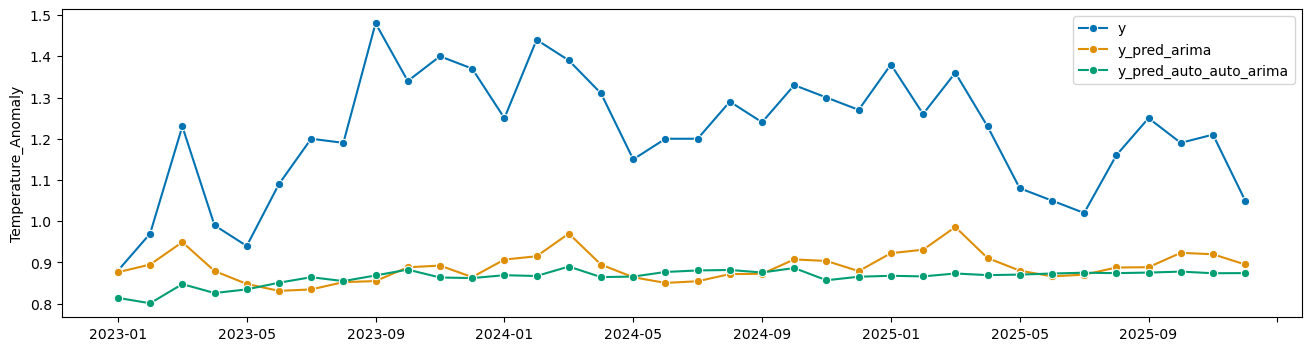

In [26]:
plot_series(y_test, y_pred_arima, y_pred_auto_arima, labels=["y", "y_pred_arima", "y_pred_auto_auto_arima"])

#### ETS

In [27]:
# Initialize and fit the ETS model
ets_model = ExponentialSmoothing(trend='additive', seasonal='additive', sp=12)
ets_model.fit(y_train)

ExponentialSmoothing(seasonal='additive', sp=12, trend='additive')

In [28]:
y_pred_ets = ets_model.predict(fh=fh)

auto_ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
auto_ets_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [29]:
auto_ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ETS Results                                  
===============================================================================
Dep. Variable:     Temperature_Anomaly   No. Observations:                 1716
Model:                        ETS(ANN)   Log Likelihood                1350.328
Date:                 Thu, 22 Jan 2026   AIC                          -2694.657
Time:                         17:53:50   BIC                          -2678.313
Sample:                     01-31-1880   HQIC                         -2688.609
                          - 12-31-2022   Scale                            0.012
Covariance Type:                approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4972      0.025     19.507      0.000       0.447       0.547
initial_level      -0.1900      0.095     -1.995      0.046      -0.377      -0.003
===================================================================================
Ljung-Box (Q):                        5.71   Jarque-Bera (JB):                36.35
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.13
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [30]:
# Forecast the next 36 months
y_pred_auto_ets = auto_ets_model.predict(fh=fh)

In [31]:
# Calculate sMAPE for each model
smape_ets = mean_absolute_percentage_error(y_test, y_pred_ets, symmetric=True)
smape_auto_ets = mean_absolute_percentage_error(y_test, y_pred_auto_ets, symmetric=True)

print(f'sMAPE (ETS): {smape_ets:.3f}')
print(f'sMAPE (AutoETS): {smape_auto_ets:.3f}')

sMAPE (ETS): 0.362
sMAPE (AutoETS): 0.381


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temperature_Anomaly'>)

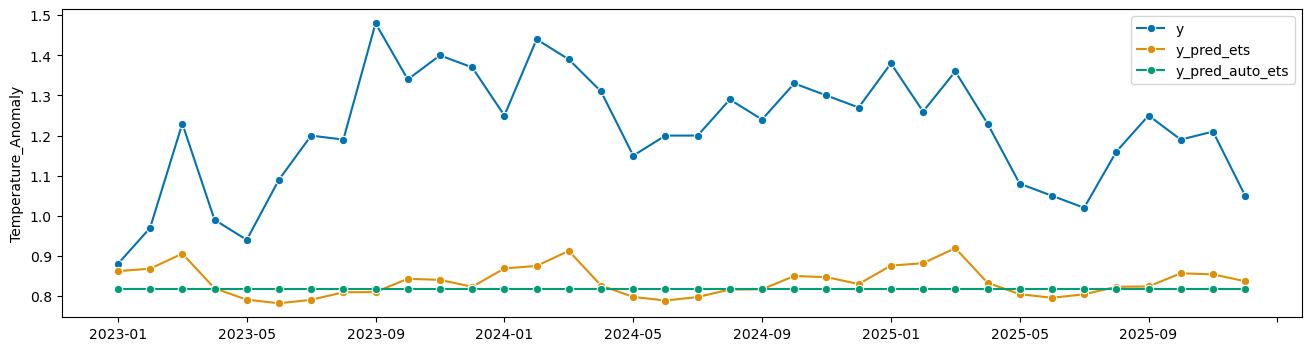

In [32]:
plot_series(y_test, y_pred_ets, y_pred_auto_ets, labels=["y", "y_pred_ets", "y_pred_auto_ets"])

#### Model Selection and Interpretation

sMAPE (ARIMA): 0.300
sMAPE (AutoARIMA): 0.328


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temperature_Anomaly'>)

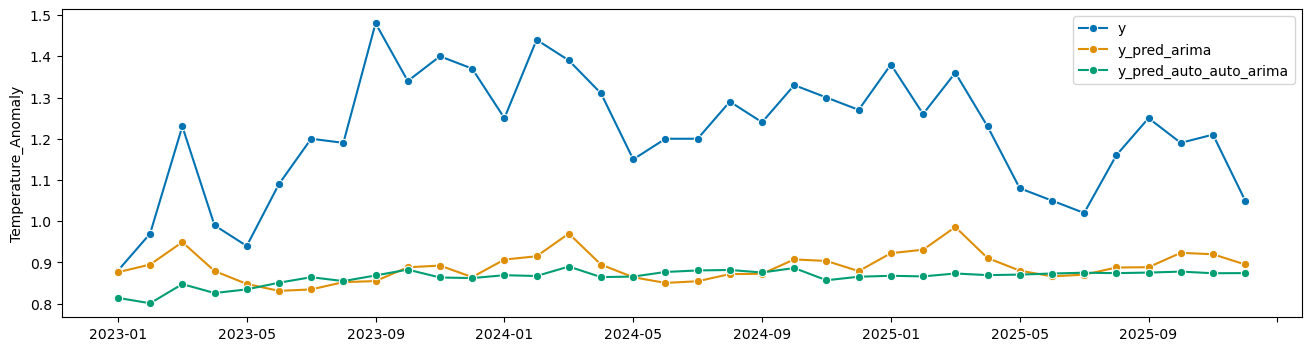

In [33]:
# TODO: Generate and visualize forecasts with the best performing model

print(f'sMAPE (ARIMA): {smape_arima:.3f}')
print(f'sMAPE (AutoARIMA): {smape_auto_arima:.3f}')

plot_series(y_test, y_pred_arima, y_pred_auto_arima, labels=["y", "y_pred_arima", "y_pred_auto_auto_arima"])

#### Best performing model
ARIMA = 0.300